In [67]:
#https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/blob/7ed3ff857940d3f4611be55f3c08c79525c32171/Metrica_PitchControl.py#L1

In [68]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import lib.draw as draw
import imageio

In [69]:
class player(object):
    """
    Class defining a player object that stores position, velocity, time-to-intercept and pitch control contributions for a player
    
    __init__ Parameters
    -----------
    pid: id (jersey number) of player
    team: row of tracking data for team
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
    
    methods include:
    -----------
    simple_time_to_intercept(r_final): time take for player to get to target position (r_final) given current position
    probability_intercept_ball(T): probability player will have controlled ball at time T given their expected time_to_intercept
    
    """
    # player object holds position, velocity, time-to-intercept and pitch control contributions for each player
    def __init__(self,pid,x,y,dx,dy,params):
        self.id = pid
        self.vmax = params['max_player_speed'] # player max speed in m/s. Could be individualised
        self.reaction_time = params['reaction_time'] # player reaction time in 's'. Could be individualised
        self.tti_sigma = params['tti_sigma'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_att = params['lambda_att'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.is_gk = False ## TODO: We do not distinguish between gks and the rest
        self.lambda_def = params['lambda_gk'] if self.is_gk else params['lambda_def'] # factor of 3 ensures that anything near the GK is likely to be claimed by the GK
        self.set_position_and_velocity(x, y, dx, dy)
        self.PPCF = 0. # initialise this for later
        
    def set_position_and_velocity(self, x, y, dx, dy):
        self.position = np.array( [ x, y ] )
        self.inframe = not np.any( np.isnan(self.position) )
        self.velocity = np.array( [ dx, dy ] )
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])
        
    def simple_time_to_intercept(self, r_final):
        self.PPCF = 0. # initialise this for later
        # Time to intercept assumes that the player continues moving at current velocity for 'reaction_time' seconds
        # and then runs at full speed to the target position.
        r_reaction = self.position + self.velocity*self.reaction_time
        self.time_to_intercept = self.reaction_time + np.linalg.norm(r_final-r_reaction)/self.vmax
        return self.time_to_intercept

    def probability_intercept_ball(self,T):
        # probability of a player arriving at target location at time 'T' given their expected time_to_intercept (time of arrival), as described in Spearman 2018
        f = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/self.tti_sigma * (T-self.time_to_intercept) ) )
        return f

In [70]:
def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params):
    """
    Calculates the pitch control probability for the attacking and defending teams at a specified target position on the ball.
    
    Parameters
    -----------
        target_position: size 2 numpy array containing the (x,y) position of the position on the field to evaluate pitch control
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_start_pos: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returrns
    -----------
        PPCFatt: Pitch control probability for the attacking team
        PPCFdef: Pitch control probability for the defending team ( 1-PPCFatt-PPCFdef <  params['model_converge_tol'] )
    """
    # calculate ball travel time from start position to end position.
    if ball_start_pos is None or any(np.isnan(ball_start_pos)): # assume that ball is already at location
        ball_travel_time = 0.0 
    else:
        # ball travel time is distance to target position from current ball position divided assumed average ball speed
        ball_travel_time = np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed']
    
    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    tau_min_def = np.nanmin( [p.simple_time_to_intercept(target_position ) for p in defending_players] )
    
    # check whether we actually need to solve equation 3
    if tau_min_att-max(ball_travel_time,tau_min_def) >= params['time_to_control_def']:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= params['time_to_control_att']:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in attacking_players if p.time_to_intercept-tau_min_att < params['time_to_control_att'] ]
        defending_players = [p for p in defending_players if p.time_to_intercept-tau_min_def < params['time_to_control_def'] ]
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-params['int_dt'],ball_travel_time+params['max_int_time'],params['int_dt']) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        while 1-ptot>params['model_converge_tol'] and i<dT_array.size: 
            T = dT_array[i]
            for player in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_att
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFatt[i] += player.PPCF # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
            for player in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_def
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFdef[i] += player.PPCF # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return PPCFatt[i-1], PPCFdef[i-1]

In [71]:
df = pd.read_csv('data/ronaldo_calma.csv')
df.edgecolor.fillna('white', inplace=True)
df.bgcolor.fillna('black', inplace=True)
df.head()

,player,frame,x,y,z,dx,dy,coords,player_num,player_obj,team,num,name,edgecolor,bgcolor
0,0,0,38.217627,15.961068,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,white,black
1,0,1,37.447818,15.742122,0.0,-0.769809,-0.218947,NaN,NaN,NaN,NaN,NaN,NaN,white,black
2,0,2,36.729118,15.537712,0.0,-0.718700,-0.204410,NaN,NaN,NaN,NaN,NaN,NaN,white,black
3,0,3,36.058134,15.346873,0.0,-0.670984,-0.190839,NaN,NaN,NaN,NaN,NaN,NaN,white,black
4,0,4,35.431698,15.168704,0.0,-0.626436,-0.178169,NaN,NaN,NaN,NaN,NaN,NaN,white,black


In [72]:
temp_file_name = '_tmp/002_tmp_laurie.png'

In [73]:
grid = pd.DataFrame([[i/1.05, j/0.68, i/1.05, j/0.68, i/1.05, j/0.68] for i in range(106) for j in range(69)], columns=['x','y','x_1dx','y_1dy','x_2dx','y_2dy'])

In [74]:
def default_model_params(time_to_control_veto=3):
    """
    Returns the default parameters that define and evaluate the model. See Spearman 2018 for more details.
    
    Parameters
    -----------
    time_to_control_veto: If the probability that another team or player can get to the ball and control it is less than 10^-time_to_control_veto, ignore that player.
    
    
    Returns
    -----------
    
    params: dictionary of parameters required to determine and calculate the model
    
    """
    # key parameters for the model, as described in Spearman 2018
    params = {}
    # model parameters
    params['max_player_accel'] = 7. # maximum player acceleration m/s/s, not used in this implementation
    params['max_player_speed'] = 5. # maximum player speed m/s
    params['reaction_time'] = 0.7 # seconds, time taken for player to react and change trajectory. Roughly determined as vmax/amax
    params['tti_sigma'] = 0.45 # Standard deviation of sigmoid function in Spearman 2018 ('s') that determines uncertainty in player arrival time
    params['kappa_def'] =  1. # kappa parameter in Spearman 2018 (=1.72 in the paper) that gives the advantage defending players to control ball, I have set to 1 so that home & away players have same ball control probability
    params['lambda_att'] = 4.3 # ball control parameter for attacking team
    params['lambda_def'] = 4.3 * params['kappa_def'] # ball control parameter for defending team
    params['lambda_gk'] = params['lambda_def']*3.0 # make goal keepers must quicker to control ball (because they can catch it)
    params['average_ball_speed'] = 15. # average ball travel speed in m/s
    # numerical parameters for model evaluation
    params['int_dt'] = 0.04 # integration timestep (dt)
    params['max_int_time'] = 10 # upper limit on integral time
    params['model_converge_tol'] = 0.01 # assume convergence when PPCF>0.99 at a given location.
    # The following are 'short-cut' parameters. We do not need to calculated PPCF explicitly when a player has a sufficient head start. 
    # A sufficient head start is when the a player arrives at the target location at least 'time_to_control' seconds before the next player
    params['time_to_control_att'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_att'])
    params['time_to_control_def'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_def'])
    return params

default_params = default_model_params()

In [75]:
frame = df[(df.frame == 0)]
attacking_team = [player(p.player,p.x,p.y,p.dx,p.dy,default_params) for _, p in df[(df.frame == 0) & (df.team == 'attack')].iterrows()]
defending_team = [player(p.player,p.x,p.y,p.dx,p.dy,default_params) for _, p in df[(df.frame == 0) & (df.team == 'defense')].iterrows()]
ball = df[(df.frame == 0) & (df.team.isna())].iloc[0][['x','y']].astype(float).to_numpy()

In [76]:
pc_results = []
for _, row in grid.iterrows():
    grid_point = row[['x', 'y']].astype(float).to_numpy()
    pc_results.append(calculate_pitch_control_at_target(grid_point, attacking_team, defending_team, ball, default_params))
grid['control'] = np.array(pc_results)[:,0]

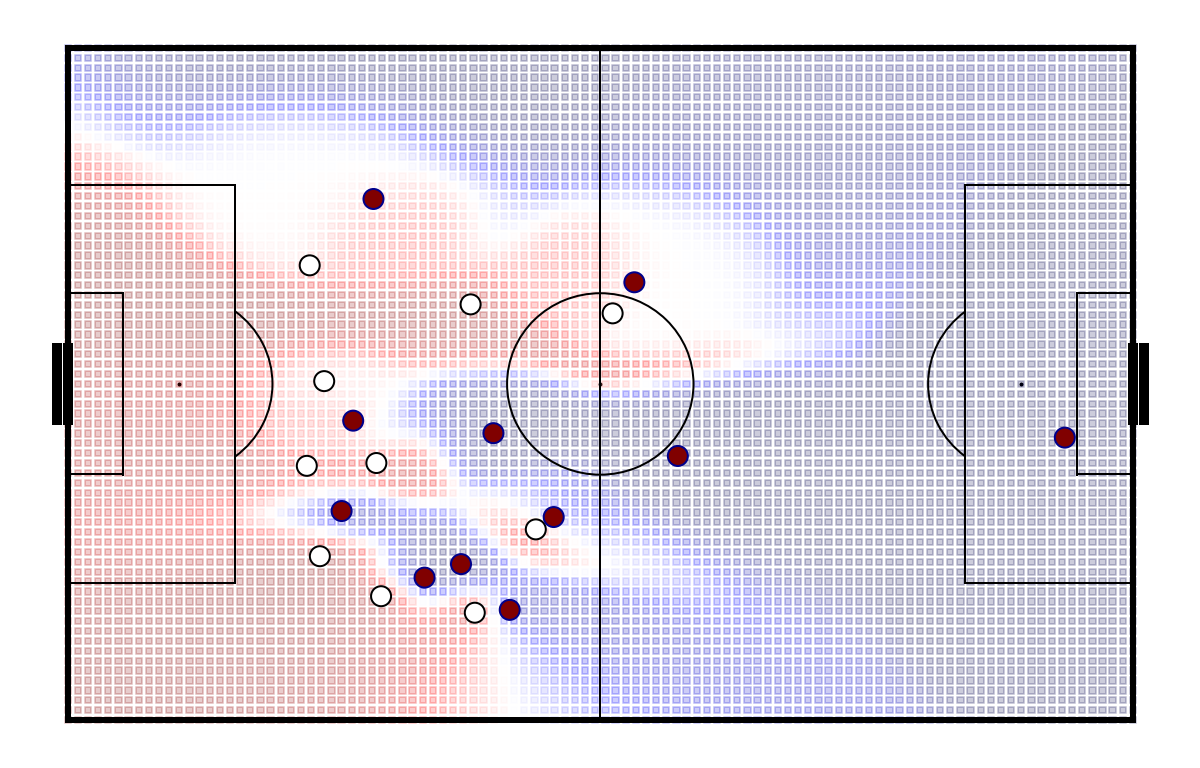

In [77]:
draw.pitch(dpi=144)
plt.scatter(grid.x, grid.y, s=10, marker='s', c=grid.control, cmap='seismic', alpha=0.2);
plt.scatter(frame.x, frame.y, s=100, c=frame.bgcolor.values, edgecolors=frame.edgecolor);

In [78]:
writer = imageio.get_writer('ronaldocalma_laurieshaw_version.gif', mode='I')
for frame_no in tqdm(df.frame.unique()):
    frame = df[df.frame==frame_no].copy()

    attacking_team = [player(p.player,p.x,p.y,p.dx,p.dy,default_params) for _, p in frame[frame.team == 'attack'].iterrows()]
    defending_team = [player(p.player,p.x,p.y,p.dx,p.dy,default_params) for _, p in frame[frame.team == 'defense'].iterrows()]
    ball = frame[frame.team.isna()].iloc[0][['x','y']].astype(float).to_numpy()

    pc_results = []
    for _, row in grid.iterrows():
        grid_point = row[['x', 'y']].astype(float).to_numpy()
        pc_results.append(calculate_pitch_control_at_target(grid_point, attacking_team, defending_team, ball, default_params))
    grid['control'] = np.array(pc_results)[:,0]

    draw.pitch(dpi=144)
    plt.scatter(grid.x, grid.y, s=10, marker='s', c=grid.control, cmap='seismic', alpha=0.2);
    plt.scatter(frame.x, frame.y, s=100, c=frame.bgcolor.values, edgecolors=frame.edgecolor);
    plt.savefig(temp_file_name, bbox_inches='tight')
    plt.clf()
    image = imageio.imread(temp_file_name)
    writer.append_data(image)

100%|██████████| 289/289 [1:22:23<00:00, 17.11s/it]


<Figure size 1512x979.2 with 0 Axes>